# MCA: Multiple Correspondence Analysis

In [1]:
import json
import pandas as pd
# ! pip install prince
import prince
from sklearn.preprocessing import OneHotEncoder
import itertools

In [2]:
omdb = json.load(open("../../../../data/parsed/omdb.json", "r") )
tmdb = json.load(open("../../../../data/parsed/tmdb.json", "r") )

In [3]:
categorical = {
    'omdb': ['Rated', 'Director', 'Genre', 'Language', 'Country', 'Type', 'Production'],
}

In [4]:
def apply_categorical(records, type, take):
    res = {i: {} for i in records.keys()}
    for row in records.keys():
        for col in records[row][type].keys():
            if col in take:
                res[row][col] = records[row][type][col]
    return res

def apply_split(records, split, limit):
    for row in records.keys():
        for col in split:
            records[row][col] = tuple(records[row][col].split(', '))
    return records

In [5]:
cat = apply_categorical(omdb, 'omdb', categorical['omdb'])
cat = apply_split(cat, ['Country', 'Language', 'Genre'], 3)
catdf = pd.DataFrame.from_dict(cat).T

### TopK One Hot

In [6]:
def one_hot(arr, name, categories):
    return dict((name+i, i in arr) for i in categories)

def apply_one_hot(records, type, name, categories):
    for row in records.keys():
        records[row] = {**records[row], **one_hot(records[row][type], name, categories)}
        del records[row][type]
    return records

genres_cat = list(set(itertools.chain(*tuple(catdf.Genre.unique()))))
language_cat = pd.Series(list(itertools.chain(*catdf.Language))).value_counts()[:30].index
countries_cat = pd.Series(list(itertools.chain(*catdf.Country))).value_counts()[:30].index

cat = apply_one_hot(cat, 'Genre', 'g_', genres_cat)
cat = apply_one_hot(cat, 'Country', 'c_', countries_cat)
cat = apply_one_hot(cat, 'Language', 'l_', language_cat)

In [7]:
catdf = pd.DataFrame.from_dict(cat).T
catdf.Rated = catdf.Rated.fillna('Not rated')
catdf.Rated[catdf.Rated == 'N/A'] = 'Not rated'
catdf.Production.fillna('-')
catdf.Production[catdf.Production == 'N/A'] = '-'
catdf.Production[catdf.Production == 'NaN'] = '-'
catdf.Production[catdf.Production.isna()] = '-'
catdf.Director.fillna('-')
catdf.Director[catdf.Director == 'N/A'] = '-'
catdf

,Director,Production,Rated,Type,c_Argentina,c_Australia,c_Austria,c_Belgium,c_Brazil,c_Canada,...,l_Norwegian,l_Persian,l_Polish,l_Portuguese,l_Romanian,l_Russian,l_Spanish,l_Swedish,l_Thai,l_Turkish
1,John Lasseter,Buena Vista,G,movie,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,Joe Johnston,Sony Pictures Home Entertainment,PG,movie,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,Howard Deutch,Warner Home Video,PG-13,movie,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,Forest Whitaker,Twentieth Century Fox Home Entertainment,R,movie,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5,Charles Shyer,Disney,PG,movie,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
6,Michael Mann,Warner Bros.,R,movie,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
7,Sydney Pollack,Paramount,PG,movie,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,Peter Hewitt,Buena Vista,PG,movie,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
9,Peter Hyams,MCA Universal Home Video,R,movie,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10,Martin Campbell,MGM/UA,PG-13,movie,False,False,False,False,False,False,...,False,False,False,False,False,True,True,False,False,False


In [21]:
mca = prince.MCA(
        n_components=16,
        n_iter=20,
        copy=True,
        check_input=True,
        engine='auto',
)
mca = mca.fit(catdf)

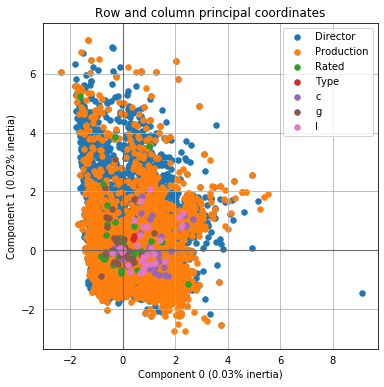

In [22]:
%matplotlib inline
ax = mca.plot_coordinates(
        X=catdf,
        ax=None,
        figsize=(6, 6),
        show_row_points=True,
        row_points_size=10,
        show_row_labels=False,
        show_column_points=True,
        column_points_size=30,
        show_column_labels=False,
        legend_n_cols=1
)

In [23]:
mca.total_inertia_

172.20652173913044

In [24]:
mca.explained_inertia_

[0.0003100434923548732,
 0.00024407550306304953,
 0.00024224620632463318,
 0.0002281484984041154,
 0.0002193046193341409,
 0.00021304012490589225,
 0.00020726702688192902,
 0.0001994318585492753,
 0.00019403911543563448,
 0.00019181206874283252,
 0.00018774890267399312,
 0.00018605508871298468,
 0.0001828472797914453,
 0.0001772822537822567,
 0.0001733821345813911,
 0.00017082486526422876]

In [34]:
transformed = mca.transform(catdf)

In [35]:
transformed.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
1,-0.315033,0.888004,-0.270955,-0.325399,-0.127805,0.127546,-0.350557,0.132797,0.039529,-0.033503,0.219357,-0.149365,-0.031039,0.060253,-0.008830,0.014681
2,-0.232859,0.302879,-0.093834,-0.123570,-0.081869,0.144205,-0.221275,0.053396,0.069158,-0.011199,0.069152,-0.049437,-0.078561,-0.018109,-0.057811,0.021046
3,-0.113806,-0.092893,-0.069021,-0.066487,-0.002543,-0.008757,-0.137554,0.046429,0.092411,0.022442,-0.083017,0.001381,-0.011375,0.074623,-0.078800,-0.024836
4,-0.162537,-0.096025,-0.038388,0.023752,0.040405,-0.036229,-0.083172,0.056144,0.104180,0.006816,-0.104356,0.043427,0.035178,-0.043913,0.108480,-0.002993
5,-0.247296,0.198804,-0.150025,-0.083692,0.017987,-0.028016,-0.229792,0.093380,0.113539,-0.011955,-0.006550,0.017402,0.017442,-0.019937,0.022055,0.024666


In [30]:
transformed.to_csv('../../../../data/engineering/mca.csv', index=False)

# Probabilistic PCA with missing data

In [1]:
import json
import pandas as pd
# ! pip install ppca
import ppca
import numpy as np

In [2]:
omdb = json.load(open("../../../../data/parsed/omdb.json", "r") )
tmdb = json.load(open("../../../../data/parsed/tmdb.json", "r") )

In [3]:
numerical = {
    'omdb': ['Year', 'Ratings', 'Metascore', 'imdbRating', 'imdbVotes'],
    'tmdb': ['budget', 'popularity', 'revenue', 'runtime', 'vote_average', 'vote_count']
}

In [4]:
def apply_numerical(records, type, take):
    res = {i: {} for i in records.keys()}
    for row in records.keys():
        for col in records[row][type].keys():
            if col in take:
                res[row][col] = records[row][type][col]
    return res

def apply_ratings(records):
    res = records.copy()
    for i in res.keys():
        for rating in res[i]['Ratings']:
            res[i]['r ' + rating['Source']] = rating['Value']
        del res[i]['Ratings']
    return res

In [5]:
numo = apply_numerical(omdb, 'omdb', numerical['omdb'])
numt = apply_numerical(tmdb, 'tmdb', numerical['tmdb'])
num = dict([(i, {**numo[i], **numt[i]}) for i in numo.keys()])
num = apply_ratings(num)

In [6]:
numdf = pd.DataFrame.from_dict(num).T
for col in numdf.columns:
    numdf[col].loc[numdf[col] == 'N/A'] = np.nan
numdf['budget'] = numdf['budget'].replace(to_replace=0, value=np.nan)
numdf['r Internet Movie Database'].loc[numdf['r Internet Movie Database'].notnull()] = \
numdf['r Internet Movie Database'].loc[numdf['r Internet Movie Database'].notnull()].apply(lambda x: x.split('/')[0])
numdf['r Metacritic'].loc[numdf['r Metacritic'].notnull()] = \
numdf['r Metacritic'].loc[numdf['r Metacritic'].notnull()].apply(lambda x: int(x.split('/')[0]))
numdf['r Rotten Tomatoes'].loc[numdf['r Rotten Tomatoes'].notnull()] = \
numdf['r Rotten Tomatoes'].loc[numdf['r Rotten Tomatoes'].notnull()].apply(lambda x: float(x.replace('%', '')))
numdf['revenue'] = numdf['revenue'].replace(to_replace=0, value=np.nan)
numdf['Year'].loc[numdf['Year'].notnull()] = numdf['Year'].loc[numdf['Year'].notnull()].apply(lambda x: int(x.replace('–', '')[0]))
numdf['imdbVotes'].loc[numdf['imdbVotes'].notnull()] = numdf['imdbVotes'].loc[numdf['imdbVotes'].notnull()].apply(lambda x: int(x.replace(',', ''))) 

/home/dev/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [7]:
numdf.head()

,Metascore,Year,budget,imdbRating,imdbVotes,popularity,r Internet Movie Database,r Metacritic,r Rotten Tomatoes,revenue,runtime,vote_average,vote_count
1,95,1,30000000.0,8.3,810875,29.3,8.3,95,100,373554033.0,81,7.9,10896
2,39,1,65000000.0,7.0,274701,5.882,7.0,39,54,262797249.0,104,7.2,6263
3,46,1,NaN,6.6,22581,8.321,6.6,46,17,NaN,101,6.6,166
4,NaN,1,16000000.0,5.9,8833,5.554,5.9,NaN,56,81452156.0,127,6.1,61
5,49,1,NaN,6.0,31738,10.859,6.0,49,48,76578911.0,106,6.1,332


In [84]:
from ppca import PPCA
ppca = PPCA()
ppca.fit(data=numdf.values.astype(float), d=16, verbose=True)
ppca.var_exp

1.0
0.4343735209843934
0.20384616046702797
0.06259686601118586
0.013438281941937524
0.0049641687442973925
0.013061575371608347
0.014889809301285695
0.013364070437484887
0.010746031450642013
0.008119285912339347
0.005876450709753067
0.00410996892539095
0.002788686237395366
0.0018371443798486098
0.0011728414993945613
0.0007220024355445442
0.00042454308953643327
0.00023415734874765448
0.00011651330072814936
4.6939171936877244e-05


array([0.4159829 , 0.67282139, 0.76269414, 0.8481815 , 0.8993178 ,
       0.93163473, 0.95744645, 0.97935228, 0.98861648])

In [88]:
transformed = ppca.transform()
transformed = pd.DataFrame(transformed)

In [90]:
transformed.head()

,0,1,2,3,4,5,6,7,8
0,7.454118,12.544648,-1.460216,4.232316,1.537817,-1.580503,-0.646091,2.641357,-0.444214
1,1.176448,5.429168,-1.256186,1.387610,0.990168,-2.363841,2.085093,-0.269463,0.873957
2,-0.786016,0.534813,-1.055434,-0.004000,-0.870945,0.643999,1.206329,-0.035866,-0.641204
3,-0.679991,0.011096,-1.270448,-0.802129,-0.230345,-0.126792,-0.255892,0.049695,0.112803
4,-0.754288,0.916379,-1.173803,-0.016951,-0.735969,0.722894,-0.116837,-0.078530,0.038348


In [89]:
transformed.to_csv('../../../../data/engineering/pca.csv', index=False)

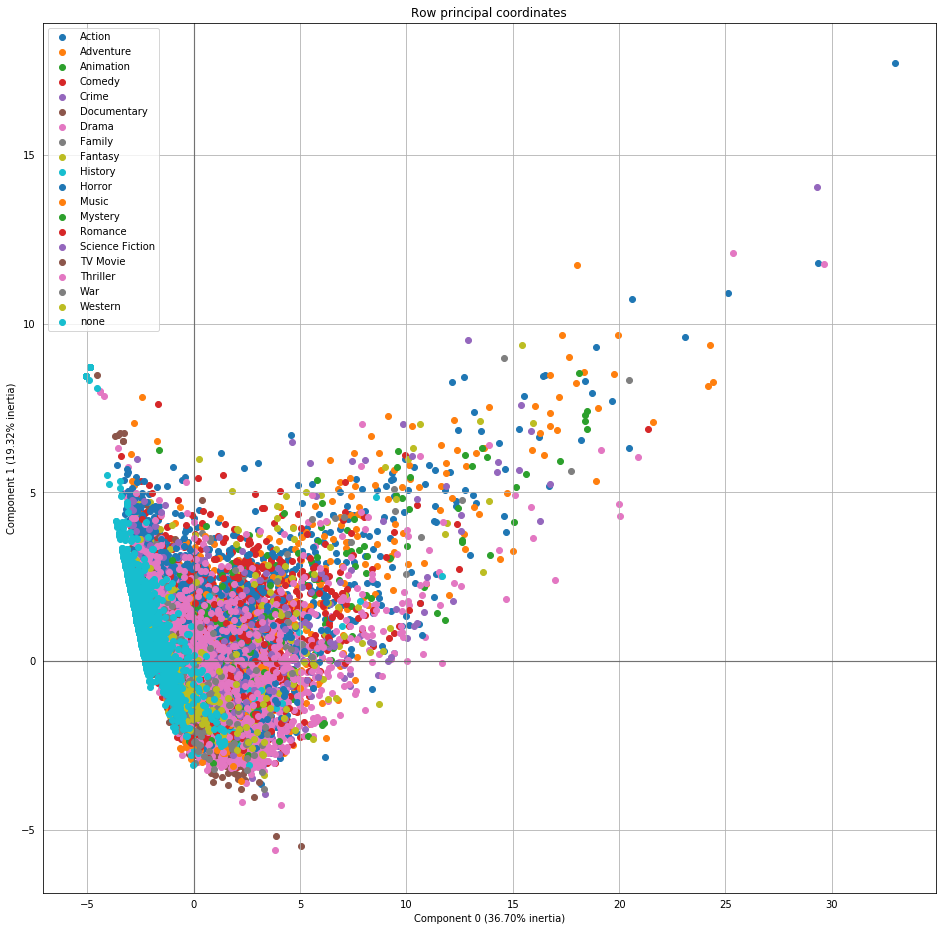

In [140]:
# Bonus: Prince's PCA visualization
# Unfortunately, Prince does not work with missing data
# So you need to use PCA Magic instead

# UMAP: Uniform Manifold Approximation and Projection

In [59]:
# Get Rid of NaNs
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
numdf = numdf.astype(float)
imputer = imputer.fit(numdf)
numdf = imputer.transform(numdf)

In [71]:
import warnings
warnings.filterwarnings('ignore')


import umap
embedding = umap.UMAP(n_neighbors=10, ).fit_transform(numdf)

In [72]:
# pretty colors
color = []
for row in tmdb.keys():
    genres = tmdb[row]['tmdb'].get('genres', False)
    if genres:
        color.append(genres[0]['id'])
    else:
        color.append('0')
le = preprocessing.LabelEncoder()
color = le.fit_transform(color)

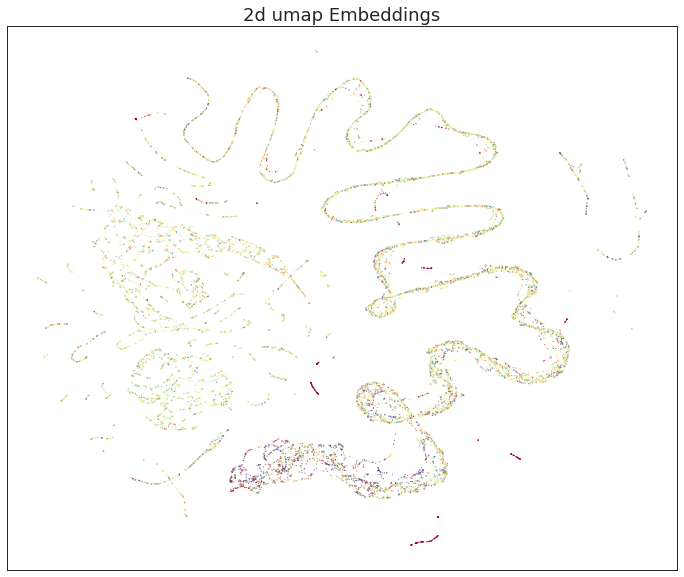

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
%matplotlib inline
sns.set(context="paper", style="white")


# color = cm.rainbow(color)
fig, ax = plt.subplots(figsize=(12, 10))
plt.scatter(
    embedding[:, 0], embedding[:, 1], c=color, cmap="Spectral", s=0.1
)
plt.setp(ax, xticks=[], yticks=[])
plt.title("2d umap Embeddings", fontsize=18)

plt.show()